<a href="https://colab.research.google.com/github/platypus2000jp/Colaboratory/blob/main/%E4%BE%8B%E9%A1%8C_%E6%B0%B4%E9%B3%A5%E3%81%AE%E3%82%AB%E3%82%A6%E3%83%B3%E3%83%88%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E3%83%99%E3%82%A4%E3%82%BA%E3%83%A2%E3%83%87%E3%83%AB_PyMC%E3%82%92%E4%BD%BF%E3%81%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


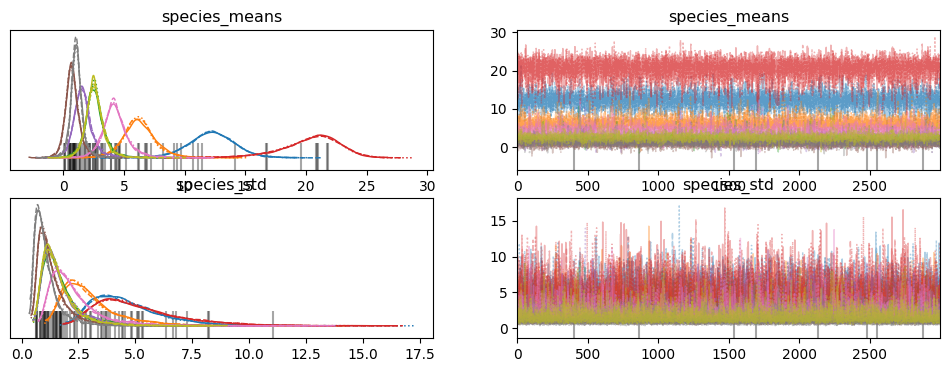

In [ ]:
# prompt: 水鳥の個体数について機械学習またはベイズのモデルの解析例を示してください。私は定点観測しており、一面に見える水鳥の複数種の個体数をカウントしています。Pythonでお願いします。PyMCを使ってください。 マガモ・コガモ・オナガガモ・オオバン・ヒシクイ・コハクチョウ・コサギ・チュウサギ・ダイサギの個体数をカウントしました。Plotlyで作表してください。3チェーンとし、収束診断も見せてください。

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import plotly.express as px
import plotly.graph_objects as go

# 観測データ（例）
data = {
    'マガモ': [10, 15, 8, 12, 18],
    'コガモ': [5, 7, 3, 6, 9],
    'オナガガモ': [2, 3, 1, 2, 4],
    'オオバン': [20, 25, 18, 22, 28],
    'ヒシクイ': [1, 2, 0, 1, 3],
    'コハクチョウ': [0, 1, 0, 0, 2],
    'コサギ': [3, 5, 2, 4, 6],
    'チュウサギ': [1, 0, 1, 1, 2],
    'ダイサギ': [2, 3, 1, 2, 4]
}
df = pd.DataFrame(data)

# モデル構築 (3チェーン)
with pm.Model() as model:
  # 種ごとの平均個体数
  species_means = pm.Normal('species_means', mu=10, sigma=5, shape=len(df.columns))

  # 種ごとの標準偏差
  species_std = pm.HalfNormal('species_std', sigma=5, shape=len(df.columns))

  # 観測データの分布
  observations = pm.Normal('observations', mu=species_means, sigma=species_std, observed=df)

  # サンプリング
  trace = pm.sample(3000, chains=3, tune=1000, return_inferencedata=True)

# 収束診断
az.summary(trace)
az.plot_trace(trace)

# 結果のプロット
species_means_posterior = trace.posterior['species_means'].values.reshape(-1, len(df.columns))
species_means_mean = np.mean(species_means_posterior, axis=0)
species_means_std = np.std(species_means_posterior, axis=0)

fig = go.Figure()
for i, species in enumerate(df.columns):
    fig.add_trace(go.Scatter(
        x=[species],
        y=[species_means_mean[i]],
        error_y=dict(type='data', array=[species_means_std[i]], visible=True),
        name=species
    ))

fig.update_layout(title='水鳥の平均個体数', xaxis_title='種', yaxis_title='個体数')
fig.show()


# 相関行列のプロット
species_correlation = np.corrcoef(species_means_posterior.T)
fig_corr = px.imshow(species_correlation,
                     labels=dict(x="種", y="種", color="相関係数"),
                     x=df.columns, y=df.columns)
fig_corr.update_layout(title="水鳥の個体数間の相関")
fig_corr.show()

In [ ]:
# prompt: 水鳥の個体数の実測値と予測値の図を見せてください。横軸のラベルは水鳥の名前である種名にしてください。上記の解析結果を利用してください。実測値と予測値は重ねてチューリッププロットにしてください。

import plotly.graph_objects as go

# 平均値と実測値をプロットするためのデータフレームを作成
plot_df = pd.DataFrame({
    '種名': df.columns.tolist() * len(df),
    '実測値': df.values.flatten(),
    '予測値': np.repeat(species_means_mean, len(df))
})

# チューリッププロットを作成
fig = px.scatter(plot_df, x='種名', y='実測値', color='種名',
                 title='水鳥の個体数：実測値と予測値')
fig.add_trace(go.Scatter(x=plot_df['種名'], y=plot_df['予測値'],
                         mode='markers', name='予測値',
                         marker=dict(color='red')))
fig.update_layout(xaxis_title='種名', yaxis_title='個体数')
fig.show()